## Ege Bölgesi için Makine Öğrenmesi Destekli Emlak Değerleme Analizi

### 1️⃣ Verilerin Yüklenmesi ve Birleştirilmesi

🟡 Gerekli paketlerin ve modüllerin yüklenmesi

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
import joblib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

hepsiemlak.com sitesinden Ege Bölgesi'nde yer alan kiralık ev ilanlarına ait veriler çekilmiştir. Bu veriler hepsiemlak klasörünün içerisindeki .csv dosyalarında bulunmaktadır. Bu dosyaların tamamını okuyarak birleştirme işlemi:

In [2]:
files = os.listdir('hepsiemlak')
df = pd.concat([pd.read_csv('hepsiemlak/' + file) for file in files], ignore_index=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   img-link href        8136 non-null   object 
 1   photo-count          8130 non-null   float64
 2   list-view-price      8136 non-null   object 
 3   list-view-date       8136 non-null   object 
 4   celly                8136 non-null   object 
 5   celly 2              8136 non-null   object 
 6   celly 3              8136 non-null   object 
 7   celly 4              6858 non-null   object 
 8   list-view-header     8129 non-null   object 
 9   list-view-location   8136 non-null   object 
 10  he-lazy-image src    7649 non-null   object 
 11  left                 8114 non-null   object 
 12  img-wrp href         4555 non-null   object 
 13  he-lazy-image src 2  4067 non-null   object 
 14  branded__text        134 non-null    object 
 15  branded__text 2      134 non-null    o

Veri seti içerisindeki sütunlar:

In [3]:
print(df.columns)

Index(['img-link href', 'photo-count', 'list-view-price', 'list-view-date',
       'celly', 'celly 2', 'celly 3', 'celly 4', 'list-view-header',
       'list-view-location', 'he-lazy-image src', 'left', 'img-wrp href',
       'he-lazy-image src 2', 'branded__text', 'branded__text 2',
       'img-wrp href 2', 'he-lazy-image src 3'],
      dtype='object')


Şimdi ve daha sonra uygulanacak sütun silme işlemleri için bir fonksiyon:

In [4]:
def drop_columns(df, cols):
    for col in cols:
        if col in df.columns:
            try:
                df.drop(col, axis=1, inplace=True)
            except Exception as e:
                print(f"Bir hata oluştu: {e}")

Kullanılmayacak sütunların silinmesi:

In [5]:
cols_to_drop = ['photo-count', 'list-view-date', 'list-view-header', 'list-view-location', 'he-lazy-image src', 'left', 'img-wrp href', 'he-lazy-image src 2', 'branded__text', 'branded__text 2', 'img-wrp href 2', 'he-lazy-image src 3']
drop_columns(df, cols_to_drop)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   img-link href    8136 non-null   object
 1   list-view-price  8136 non-null   object
 2   celly            8136 non-null   object
 3   celly 2          8136 non-null   object
 4   celly 3          8136 non-null   object
 5   celly 4          6858 non-null   object
dtypes: object(6)
memory usage: 381.5+ KB
None


🟡 `img-link href` sütunundan şehir, ilçe ve mahalle bilgilerinin çıkarılması:

In [6]:
df['location'] = df['img-link href'].apply(lambda x: x.split('/')[3])
df['city'] = df['location'].str.split('-').str[0]
df['district'] = df['location'].str.split('-').str[1]
df['neighborhood'] = df['location'].str.split('-').str[2:-1]
df['neighborhood'] = df['neighborhood'].apply(lambda x: '_'.join(x))

In [7]:
drop_columns(df, ['location', 'img-link href'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   list-view-price  8136 non-null   object
 1   celly            8136 non-null   object
 2   celly 2          8136 non-null   object
 3   celly 3          8136 non-null   object
 4   celly 4          6858 non-null   object
 5   city             8136 non-null   object
 6   district         8136 non-null   object
 7   neighborhood     8136 non-null   object
dtypes: object(8)
memory usage: 508.6+ KB
None


🟡 Oda ve salon sayılarının ayrılması:

In [8]:
print(df['celly'].unique())

['3 +\n                        1' '2 +\n                        1'
 '1 +\n                        1' '4 +\n                        1'
 '2 +\n                        0' 'Stüdyo'
 '3 +\n                        0' '1 +\n                        15'
 '2 +\n                        2' '6 +\n                        2'
 '4 +\n                        2' '3 +\n                        2'
 '9 +\n                        1' '6 +\n                        1'
 '8 +\n                        1' '5 +\n                        1'
 '41 +\n                        4' '4 +\n                        0'
 '5 +\n                        2' '1 +\n                        25'
 '7 +\n                        1' '21 +\n                        1'
 '7 +\n                        2' '6 +\n                        0'
 '9 +\n                        4' '4 +\n                        4'
 '3 +\n                        3' '31 +\n                        1'
 '9 +\n                        3' '25 +\n                        5'
 '8 +\n      

In [9]:
df['celly'] = df['celly'].apply(lambda x: x.replace('Stüdyo', '1 + 0'))
df['celly'] = df['celly'].apply(lambda x: x.replace('\n', ''))
df['room'] = df['celly'].apply(lambda x: x.split('+')[0]).astype(int)
df['living_room'] = df['celly'].apply(lambda x: x.split('+')[1]).astype(int)

In [10]:
print(df['room'].unique())
print(df['living_room'].unique())

[ 3  2  1  4  6  9  8  5 41  7 21 31 25 14 10]
[ 1  0 15  2  4 25  3  5  9  6]


In [11]:
drop_columns(df, ['celly'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   list-view-price  8136 non-null   object
 1   celly 2          8136 non-null   object
 2   celly 3          8136 non-null   object
 3   celly 4          6858 non-null   object
 4   city             8136 non-null   object
 5   district         8136 non-null   object
 6   neighborhood     8136 non-null   object
 7   room             8136 non-null   int64 
 8   living_room      8136 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 572.2+ KB
None


🟡 Metrekare değerlerinin ayrılması:

In [12]:
print(df['celly 2'].unique())

['150 m²' '110 m²' '60 m²' '50 m²' '300 m²' '117 m²' '70 m²' '140 m²'
 '130 m²' '75 m²' '160 m²' '165 m²' '135 m²' '85 m²' '120 m²' '48 m²'
 '125 m²' '80 m²' '95 m²' '100 m²' '105 m²' '180 m²' '3.200 m²' '90 m²'
 '76 m²' '55 m²' '65 m²' '145 m²' '45 m²' '115 m²' '35 m²' '53 m²'
 '155 m²' '148 m²' '78 m²' '151 m²' '30 m²' '270 m²' '440 m²' '132 m²'
 '121 m²' '141 m²' '170 m²' '122 m²' '200 m²' '87 m²' '146 m²' '220 m²'
 '108 m²' '370 m²' '86 m²' '380 m²' '47 m²' '43 m²' '63 m²' '245 m²'
 '204 m²' '183 m²' '190 m²' '600 m²' '119 m²' '72 m²' '350 m²' '142 m²'
 '520 m²' '166 m²' '870 m²' '330 m²' '96 m²' '41 m²' '143 m²' '280 m²'
 '64 m²' '57 m²' '286 m²' '340 m²' '81 m²' '185 m²' '40 m²' '168 m²'
 '116 m²' '93 m²' '209 m²' '59 m²' '77 m²' '400 m²' '98 m²' '106 m²'
 '174 m²' '205 m²' '74 m²' '500 m²' '68 m²' '1.301 m²' '275 m²' '52 m²'
 '137 m²' '167 m²' '217 m²' '25 m²' '250 m²' '290 m²' '112 m²' '196 m²'
 '184 m²' '450 m²' '159 m²' '195 m²' '640 m²' '230 m²' '260 m²' '285 m²'
 '235 m²' '

In [13]:
df['celly 2'] = df['celly 2'].apply(lambda x: x.replace('.', ''))
df['area'] = df['celly 2'].apply(lambda x: x.split(' ')[0]).astype(int)

In [14]:
print(df['area'].unique())

[ 150  110   60   50  300  117   70  140  130   75  160  165  135   85
  120   48  125   80   95  100  105  180 3200   90   76   55   65  145
   45  115   35   53  155  148   78  151   30  270  440  132  121  141
  170  122  200   87  146  220  108  370   86  380   47   43   63  245
  204  183  190  600  119   72  350  142  520  166  870  330   96   41
  143  280   64   57  286  340   81  185   40  168  116   93  209   59
   77  400   98  106  174  205   74  500   68 1301  275   52  137  167
  217   25  250  290  112  196  184  450  159  195  640  230  260  285
  235  337  211  240  134  832 1000   38  147  152   88  213  126  255
  199  127   11  154   22   66  399  187   67  210   89  355   97   84
   42   51   73  325   71 3000  175  320  156  162   18   56  136  131
  580  375  161  163  149  206  138  475  359  124   91  194 4500   20
  103   58  302  505  800  368  178  750   92  181  460  390  360  550
 4000  295  128  341  745  118  144   15   82   49  176  182  981  256
   62 

In [15]:
drop_columns(df, ['celly 2'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   list-view-price  8136 non-null   object
 1   celly 3          8136 non-null   object
 2   celly 4          6858 non-null   object
 3   city             8136 non-null   object
 4   district         8136 non-null   object
 5   neighborhood     8136 non-null   object
 6   room             8136 non-null   int64 
 7   living_room      8136 non-null   int64 
 8   area             8136 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 572.2+ KB
None


🟡 Bina yaşı değerlerinin ayrılması:

In [16]:
print(df['celly 3'].unique())

['20\n                      Yaşında' '8\n                      Yaşında'
 'Sıfır Bina' '10\n                      Yaşında'
 '11\n                      Yaşında' '5\n                      Yaşında'
 '4\n                      Yaşında' '3\n                      Yaşında'
 '15\n                      Yaşında' '1\n                      Yaşında'
 '24\n                      Yaşında' '2\n                      Yaşında'
 '17\n                      Yaşında' '30\n                      Yaşında'
 '28\n                      Yaşında' '25\n                      Yaşında'
 '16\n                      Yaşında' '21\n                      Yaşında'
 '18\n                      Yaşında' '31\n                      Yaşında'
 '22\n                      Yaşında' '7\n                      Yaşında'
 '13\n                      Yaşında' '9\n                      Yaşında'
 '6\n                      Yaşında' '35\n                      Yaşında'
 '39\n                      Yaşında' '14\n                      Yaşında'
 '19\n    

In [17]:
df['celly 3'] = df['celly 3'].apply(lambda x: x.replace('Sıfır Bina', '0 Yaşında'))
df['celly 3'] = df['celly 3'].apply(lambda x: x.replace('\n', ' '))
df['age'] = df['celly 3'].apply(lambda x: x.split(' ')[0]).astype(int)

In [18]:
print(df['age'].unique())

[ 20   8   0  10  11   5   4   3  15   1  24   2  17  30  28  25  16  21
  18  31  22   7  13   9   6  35  39  14  19  33  26  12  29  49  27  32
  52  40  38  44  50  34  23  45  42  55  36  43  37  47 300  48 199 100
  60  61 600]


In [19]:
drop_columns(df, ['celly 3'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   list-view-price  8136 non-null   object
 1   celly 4          6858 non-null   object
 2   city             8136 non-null   object
 3   district         8136 non-null   object
 4   neighborhood     8136 non-null   object
 5   room             8136 non-null   int64 
 6   living_room      8136 non-null   int64 
 7   area             8136 non-null   int64 
 8   age              8136 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 572.2+ KB
None


🟡 Evin bulunduğu kat bilgilerinin ayrılması:

In [20]:
print(df['celly 4'].unique())

['Kot 2' '1. Kat' '4. Kat' '5. Kat' '7. Kat' '3. Kat' '2. Kat' 'Kot 1'
 'Yüksek Giriş' '9. Kat' 'Ara Kat' 'En Üst Kat' 'Bahçe Katı' 'Yarı Bodrum'
 nan 'Bodrum' 'Kot 3' 'Çatı Katı' 'Zemin' '8. Kat' 'Giriş Katı' '6. Kat'
 '16. Kat' '17. Kat' 'Villa Katı' '10. Kat' '13. Kat' '12. Kat' '11. Kat'
 '14. Kat' '21 ve üzeri' 'Bodrum ve Zemin' 'Asma Kat' '18. Kat' 'Tripleks'
 'Teras Katı' '15. Kat' '20. Kat' '19. Kat']


In [21]:
replace_dict = {
    'Kot 2': '-2. Kat',
    'Kot 1': '-1. Kat',
    'Yüksek Giriş': '1. Kat',
    'Ara Kat': '3. Kat',
    'En Üst Kat': '5. Kat',
    'Bahçe Katı': '0. Kat',
    'Yarı Bodrum': '0. Kat',
    'Bodrum': '0. Kat',
    'Kot 3': '-3. Kat',
    'Çatı Katı': '5. Kat',
    'Zemin': '0. Kat',
    'Giriş Katı': '0. Kat',
    'Villa Katı': '0. Kat',
    '21 ve üzeri': '21. Kat',
    'Bodrum ve Zemin': '0. Kat',
    'Asma Kat': '1. Kat',
    'Tripleks': '0. Kat',
    'Teras Katı': '5. Kat',
}
df['celly 4'] = df['celly 4'].replace(replace_dict.keys(), replace_dict.values()).astype(str)
df['celly 4'] = df['celly 4'].apply(lambda x: x.replace('nan', '2. Kat'))
df['floor'] = df['celly 4'].apply(lambda x: x.split('.')[0]).astype(int)

In [22]:
print(df['floor'].unique())

[-2  1  4  5  7  3  2 -1  9  0 -3  8  6 16 17 10 13 12 11 14 21 18 15 20
 19]


In [23]:
drop_columns(df, ['celly 4'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   list-view-price  8136 non-null   object
 1   city             8136 non-null   object
 2   district         8136 non-null   object
 3   neighborhood     8136 non-null   object
 4   room             8136 non-null   int64 
 5   living_room      8136 non-null   int64 
 6   area             8136 non-null   int64 
 7   age              8136 non-null   int64 
 8   floor            8136 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 572.2+ KB
None


🟡 Kira değerlerinin ayrılması:

In [24]:
print(df['list-view-price'].unique())

[7.0 8.5 16.5 20.0 22.0 7.25 15.0 10.0 7.5 6.75 21.0 14.0 8.0 '7.500'
 '8.500' '15.000' '5.000' '7.000' '8.000' '11.000' '9.000' '3.000'
 '10.000' '6.500' '2.500' '6.000' '5.500' '8.750' '4.250' '4.500' '12.500'
 '5.250' '12.000' '7.250' '6.750' '7.750' '3.500' '6.600' '5.100' '13.000'
 '5.600' '1.100.000' '9.500' '4.000' '13.250' '19.000' '29.000' '30.000'
 '25.000' '18.500' '83.000' '14.000' '380.000' '20.000' '210.000'
 '280.000' '325.000' '16.000' '9.250' '37.500' '600.000' '350' '15.500'
 '500.000' '200.000' '20.500' '13.500' '11.500' '17.000' '800.000'
 '10.500' '22.000' '18.000' '50.000' '65.000' '550.000' '45.000' '33.000'
 '100.000' '21.500' '28.500' '26.000' '22.500' '220.000' '400.000'
 '39.000' '27.500' '16.500' '29.500' '15.750' '40.000' '21.750' '35.000'
 '25.500' '21.000' '235.000' '34.000' '96.000' '55.000' '425.000' '24.000'
 '23.000' '19.750' '70.000' '52.500' '32.000' '450.000' '275.000' '19.360'
 '620.000' '17.500' '19.500' '370.000' '350.000' '9.800' '680.000'
 '15

In [25]:
df['list-view-price'] = df['list-view-price'].astype(str).apply(lambda x: x.replace('.', ''))
df['price'] = df['list-view-price'].astype(int)

In [26]:
print(df['price'].unique())

[       70        85       165       200       220       725       150
       100        75       675       210       140        80      7500
      8500     15000      5000      7000      8000     11000      9000
      3000     10000      6500      2500      6000      5500      8750
      4250      4500     12500      5250     12000      7250      6750
      7750      3500      6600      5100     13000      5600   1100000
      9500      4000     13250     19000     29000     30000     25000
     18500     83000     14000    380000     20000    210000    280000
    325000     16000      9250     37500    600000       350     15500
    500000    200000     20500     13500     11500     17000    800000
     10500     22000     18000     50000     65000    550000     45000
     33000    100000     21500     28500     26000     22500    220000
    400000     39000     27500     16500     29500     15750     40000
     21750     35000     25500     21000    235000     34000     96000
     5

In [27]:
drop_columns(df, ['list-view-price'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          8136 non-null   object
 1   district      8136 non-null   object
 2   neighborhood  8136 non-null   object
 3   room          8136 non-null   int64 
 4   living_room   8136 non-null   int64 
 5   area          8136 non-null   int64 
 6   age           8136 non-null   int64 
 7   floor         8136 non-null   int64 
 8   price         8136 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 572.2+ KB
None


💾 Veri setinin kaydedilmesi:

In [28]:
df.to_csv('hepsiemlak.csv', index=False)

### 2️⃣ Verilerin istatistiksel olarak incelenmesi ve aykırı değerlerin temizlenmesi

In [29]:
del df
df = pd.read_csv('hepsiemlak.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          8136 non-null   object
 1   district      8136 non-null   object
 2   neighborhood  8136 non-null   object
 3   room          8136 non-null   int64 
 4   living_room   8136 non-null   int64 
 5   area          8136 non-null   int64 
 6   age           8136 non-null   int64 
 7   floor         8136 non-null   int64 
 8   price         8136 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 572.2+ KB
None


In [30]:
df['city'] = df['city'].astype('category')
df['district'] = df['district'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')
df['room'] = df['room'].astype('int')
df['living_room'] = df['living_room'].astype('int')
df['area'] = df['area'].astype('int')
df['age'] = df['age'].astype('int')
df['floor'] = df['floor'].astype('int')
df['price'] = df['price'].astype('int')

In [31]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city          8136 non-null   category
 1   district      8136 non-null   category
 2   neighborhood  8136 non-null   category
 3   room          8136 non-null   int64   
 4   living_room   8136 non-null   int64   
 5   area          8136 non-null   int64   
 6   age           8136 non-null   int64   
 7   floor         8136 non-null   int64   
 8   price         8136 non-null   int64   
dtypes: category(3), int64(6)
memory usage: 438.2 KB
None


🟡 Sayısal değişkenlerin çeyreklik aralıklarını kullanarak minimum ve maximum değerlerinin bulunması

In [32]:
columns = df.select_dtypes(include=[np.number]).columns
min_values = []
max_values = []
for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    min_value = Q1 - 1.5 * IQR
    max_value = Q3 + 1.5 * IQR
    min_values.append(min_value)
    max_values.append(max_value)
    print(f"Column: {column}, min: {min_value}, max: {max_value}")

Column: room, min: 0.5, max: 4.5
Column: living_room, min: 1.0, max: 1.0
Column: area, min: -17.5, max: 242.5
Column: age, min: -20.0, max: 44.0
Column: floor, min: -2.0, max: 6.0
Column: price, min: -18000.0, max: 62000.0


🟡 Aykırı değerlerin temizlenmesi

In [33]:
for i, column in enumerate(columns):
    df = df[(df[column] >= min_values[i]) & (df[column] <= max_values[i])]

In [34]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6212 entries, 0 to 8134
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city          6212 non-null   category
 1   district      6212 non-null   category
 2   neighborhood  6212 non-null   category
 3   room          6212 non-null   int64   
 4   living_room   6212 non-null   int64   
 5   area          6212 non-null   int64   
 6   age           6212 non-null   int64   
 7   floor         6212 non-null   int64   
 8   price         6212 non-null   int64   
dtypes: category(3), int64(6)
memory usage: 388.9 KB
None


🟡 Ek bir kontrol için değerlerin kontrol edilmesi

In [35]:
print(df.describe())

              room  living_room         area          age        floor  \
count  6212.000000       6212.0  6212.000000  6212.000000  6212.000000   
mean      2.176272          1.0   104.669350    12.653896     2.199614   
std       0.826815          0.0    39.442494    10.451565     1.589618   
min       1.000000          1.0     5.000000     0.000000    -2.000000   
25%       2.000000          1.0    75.000000     4.000000     1.000000   
50%       2.000000          1.0   100.000000    10.000000     2.000000   
75%       3.000000          1.0   130.000000    20.000000     3.000000   
max       4.000000          1.0   240.000000    44.000000     6.000000   

              price  
count   6212.000000  
mean   17900.975853  
std    10467.582893  
min        1.000000  
25%    11000.000000  
50%    15000.000000  
75%    21000.000000  
max    60000.000000  


🟡 Kira değeri için elle düzeltme

In [36]:
df = df[df['price'] >= 3000]

In [37]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6116 entries, 23 to 8134
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city          6116 non-null   category
 1   district      6116 non-null   category
 2   neighborhood  6116 non-null   category
 3   room          6116 non-null   int64   
 4   living_room   6116 non-null   int64   
 5   area          6116 non-null   int64   
 6   age           6116 non-null   int64   
 7   floor         6116 non-null   int64   
 8   price         6116 non-null   int64   
dtypes: category(3), int64(6)
memory usage: 383.3 KB
None


💾 Temizlenmiş ve ayıklanmış verilerin kaydedilmesi

In [38]:
df.to_csv('hepsiemlak_cleaned.csv', index=False)

### 3️⃣ Verilerin Görselleştirilmesi

In [39]:
del df
df = pd.read_csv('hepsiemlak_cleaned.csv')

🟡 Verilerin dağılımlarının görselleştirilmesi

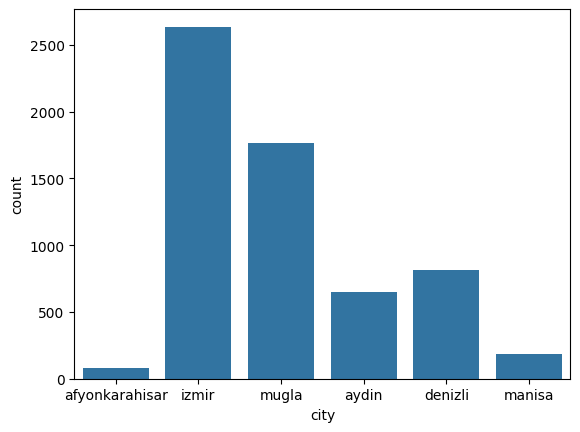

In [40]:
sns.countplot(x='city', data=df)
plt.show()

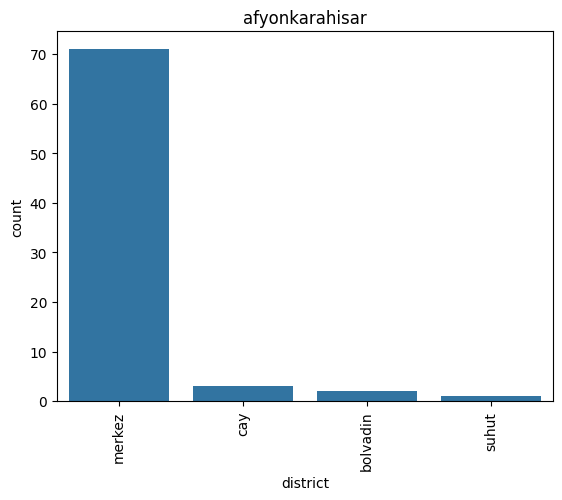

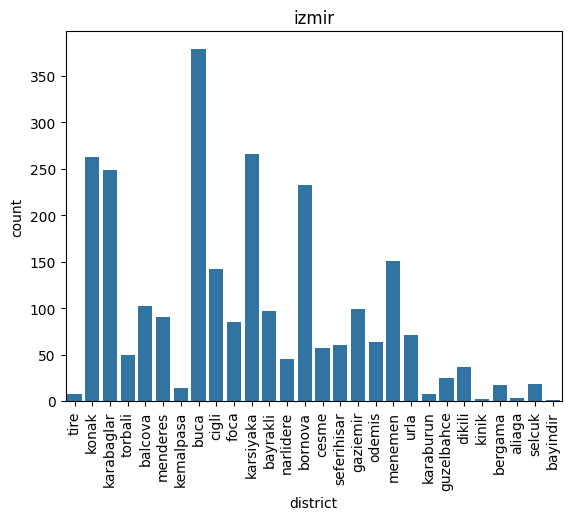

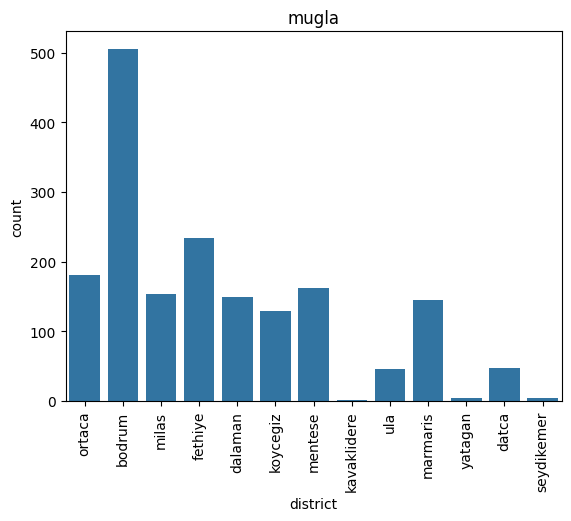

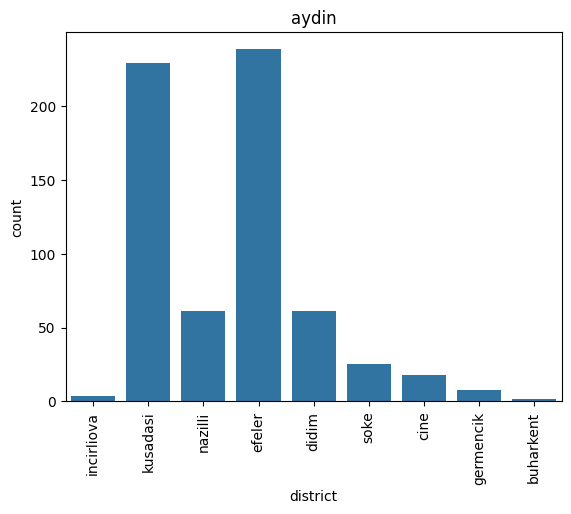

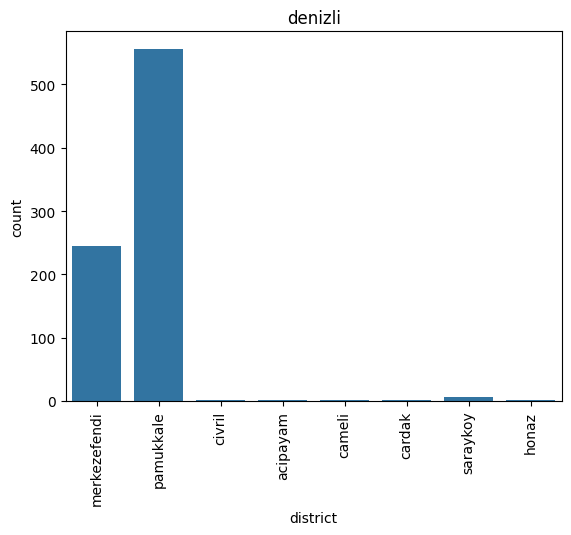

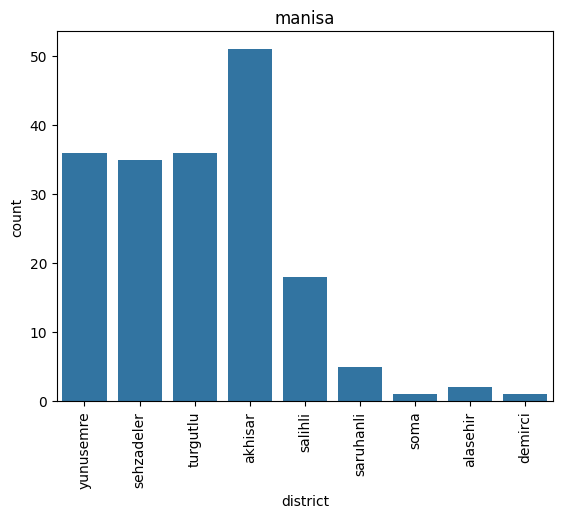

In [41]:
for city in df['city'].unique():
    sns.countplot(x='district', data=df[df['city'] == city])
    plt.title(city)
    plt.xticks(rotation=90)
    plt.show()

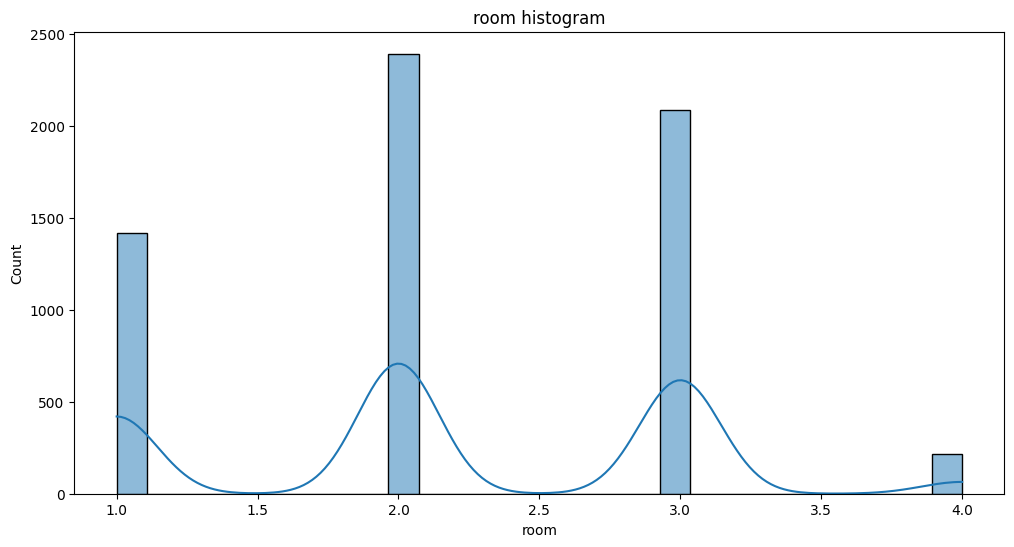

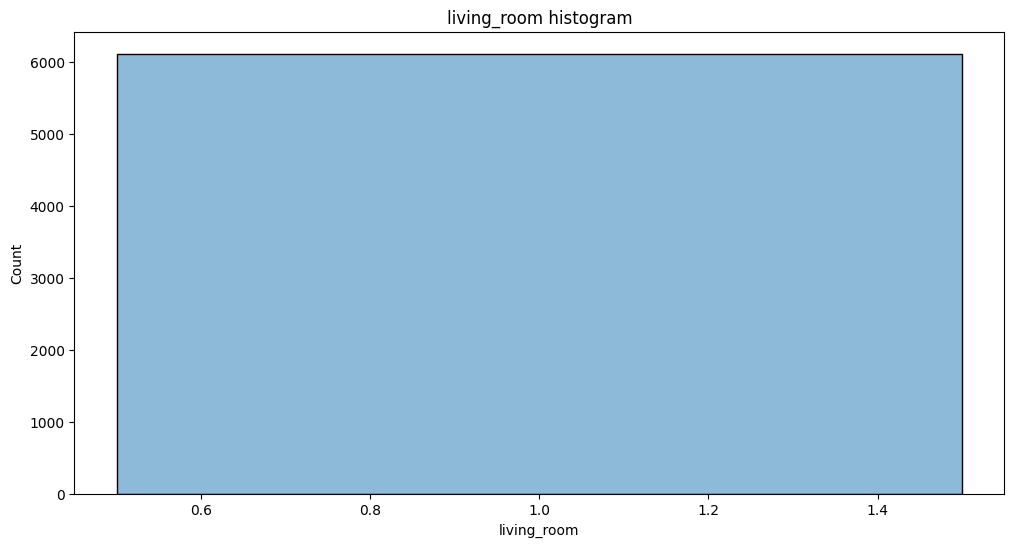

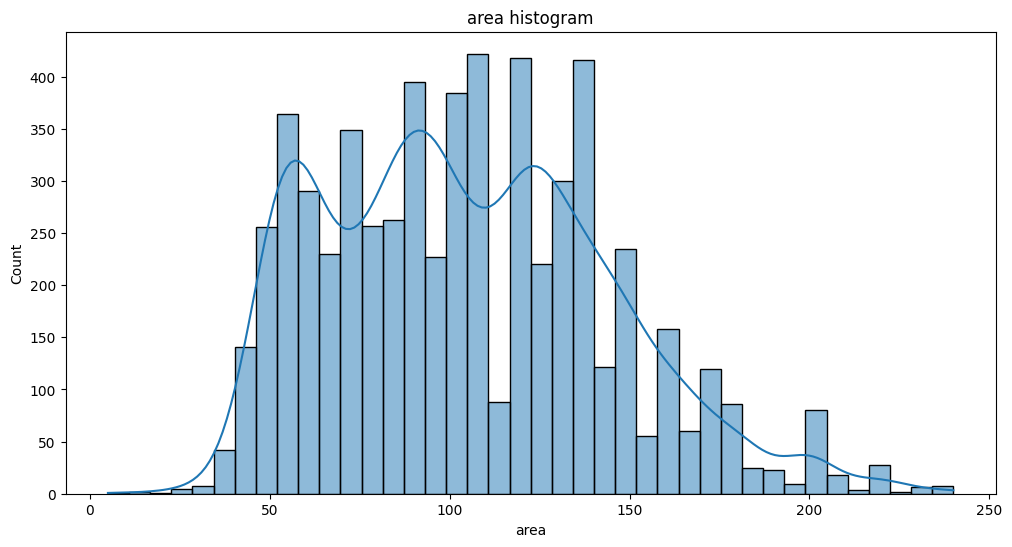

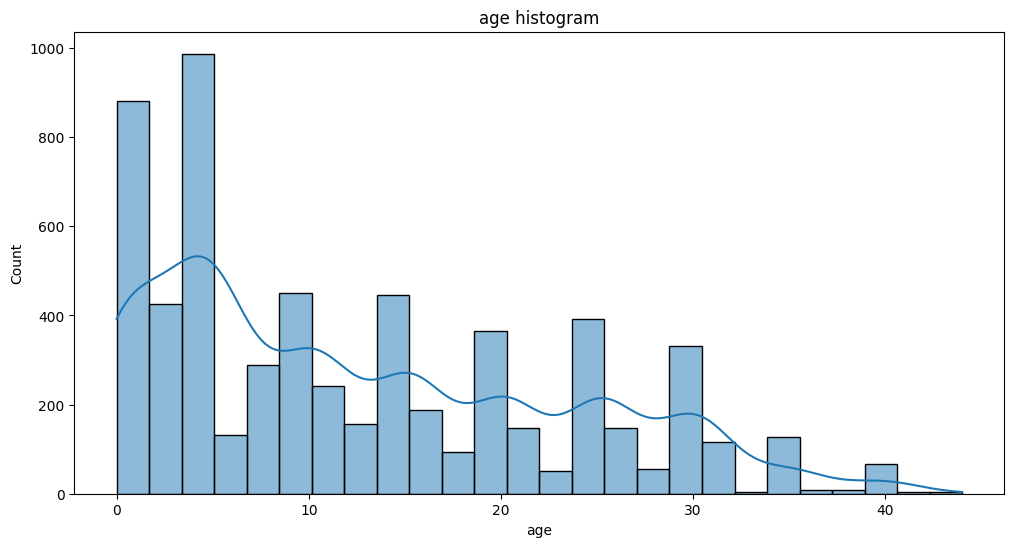

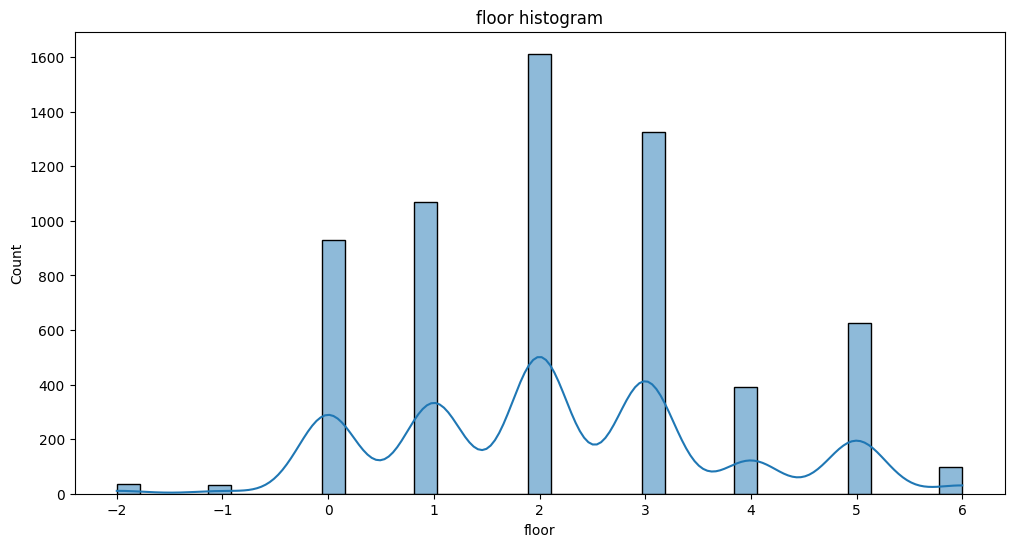

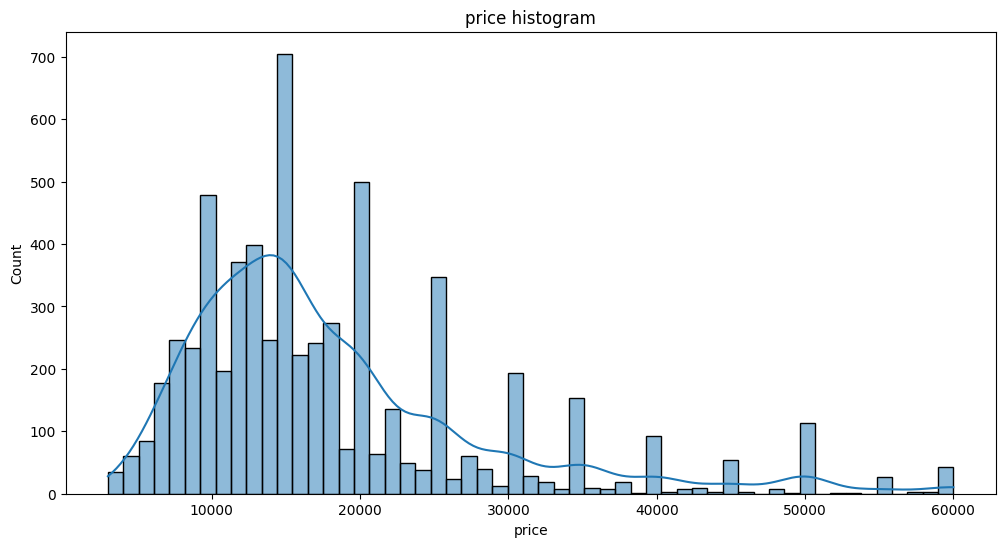

In [42]:
columns = df.select_dtypes(include=[np.number]).columns
for column in columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'{column} histogram')
    plt.show()

🟡 Sayısal değişkenler için korelasyon matrisi

<Axes: >

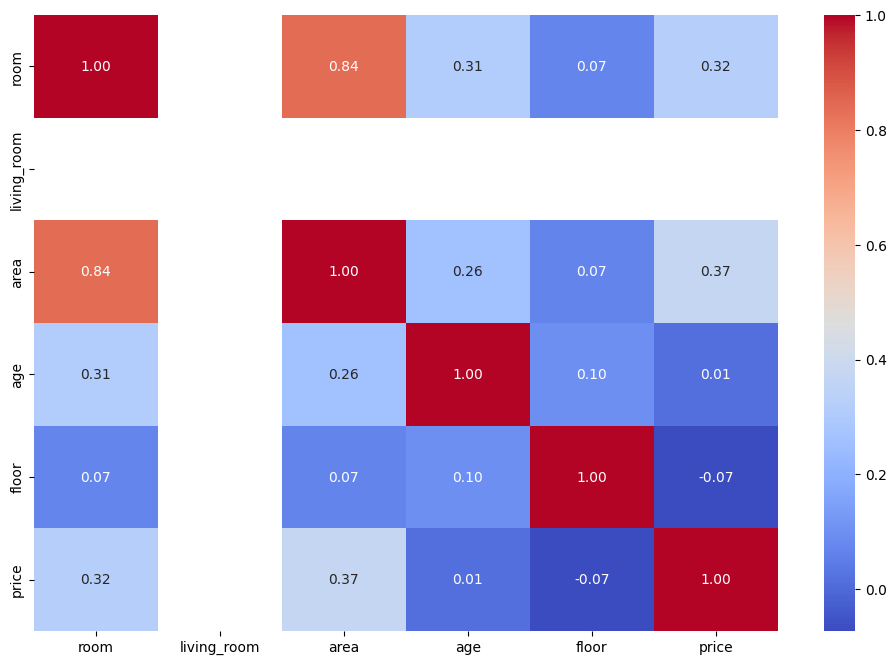

In [43]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[['room', 'living_room', 'area', 'age', 'floor', 'price']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

#### 4️⃣ Verilerin lineer regresyon modeli ile değerlendirilmesi

In [44]:
del df
df = pd.read_csv('hepsiemlak_cleaned.csv')

In [45]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          6116 non-null   object
 1   district      6116 non-null   object
 2   neighborhood  6116 non-null   object
 3   room          6116 non-null   int64 
 4   living_room   6116 non-null   int64 
 5   area          6116 non-null   int64 
 6   age           6116 non-null   int64 
 7   floor         6116 non-null   int64 
 8   price         6116 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 430.2+ KB
None


In [46]:
df['city'] = df['city'].astype('category')
df['district'] = df['district'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')
df['room'] = df['room'].astype('int')
df['living_room'] = df['living_room'].astype('int')
df['area'] = df['area'].astype('int')
df['age'] = df['age'].astype('int')
df['floor'] = df['floor'].astype('int')
df['price'] = df['price'].astype('int')

In [47]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city          6116 non-null   category
 1   district      6116 non-null   category
 2   neighborhood  6116 non-null   category
 3   room          6116 non-null   int64   
 4   living_room   6116 non-null   int64   
 5   area          6116 non-null   int64   
 6   age           6116 non-null   int64   
 7   floor         6116 non-null   int64   
 8   price         6116 non-null   int64   
dtypes: category(3), int64(6)
memory usage: 335.0 KB
None


🟡 Kategorik değişkenlere one hot encoding, sayısal değişkenlere standard scaling dönüşümü uygulanması

In [48]:
categorical_features = ['city', 'district', 'neighborhood']
numerical_features = ['room', 'living_room', 'area', 'age', 'floor']

In [49]:
full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

🟡 X matrisinin ve y vektörünün oluşturulması ve train - test gruplarına ayrılması

In [50]:
X = df.drop(['price'], axis=1)
y = df['price']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

🟡 Modelin oluşturulması ve fit işleminin yapılması

In [52]:
model = Pipeline([
    ('preparation', full_pipeline),
    ('model', LinearRegression())
])

In [53]:
model.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['room', 'living_room',
                                                   'area', 'age', 'floor']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'district',
                                                   'neighborhood'])])),
                ('model', LinearRegression())])

🟡 Modelin başarısının değerlendirilmesi

In [54]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MSE: 48099254.80915588
RMSE: 6935.3626299679445
R^2: 0.5897261079812823


🟡 Değişkenlerin önemlerinin gösterilmesi

In [55]:
intercept = model.named_steps['model'].intercept_
feature_importances = model.named_steps['model'].coef_

print(f"Intercept: {intercept}")
print()
print("Numerical Features")
for i in range(len(numerical_features)):
    print(numerical_features[i], feature_importances[i])
print()
print("Categorical Features")
for i in range(len(categorical_features)):
    for j in range(len(model.named_steps['preparation'].transformers_[1][1].categories_[i])):
        print(model.named_steps['preparation'].transformers_[1][1].categories_[i][j], feature_importances[len(numerical_features) + j])

Intercept: 12298.79525315412

Numerical Features
room 771.39145891298
living_room 0.0
area 3450.611155474665
age -2075.411728546521
floor 162.0262111943727

Categorical Features
afyonkarahisar -5560.498937824713
aydin 1784.278043556758
denizli -3444.2102982140586
izmir 6390.563613032616
manisa -1903.855211795589
mugla 2733.7227911882187
acipayam -5560.498937824713
akhisar 1784.278043556758
alasehir -3444.2102982140586
aliaga 6390.563613032616
balcova -1903.855211795589
bayindir 2733.7227911882187
bayrakli -941.501985129468
bergama 10.140388312072075
bodrum -2320.7037609002145
bolvadin 1556.2458441940946
bornova 6352.092870125386
buca -7426.699081356405
buharkent -4365.836919110257
cardak -5014.424300118075
cay 16330.207659839378
cesme -533.0028452142279
cigli -2026.7063102723137
cine -2085.1978629265836
civril -1822.9260118159589
dalaman -1460.2150917354727
datca -5966.520931464428
didim 17527.641408221094
dikili -4632.597519711589
efeler -1757.900986061785
fethiye -2365.397553255053
f

🟡 Mutlak ve yüzdelik olarak töleranslı r^2 hesabı yapan fonksiyonlar:

In [56]:
def tolerance_r2(y_true, y_pred, tolerance):
    residuals = y_pred - y_true
    residuals[np.abs(residuals) <= tolerance] = 0
    ssr = np.sum(residuals**2)
    sst = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ssr / sst)

def tolerance_percentage_r2(y_true, y_pred, tolerance):
    residuals = y_pred - y_true
    residuals[(np.abs(residuals) / y_true) <= tolerance] = 0
    ssr = np.sum(residuals**2)
    sst = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ssr / sst)

In [57]:
print(r2_score(y_test, y_pred))
print(tolerance_r2(y_test, y_pred, 5000))
print(tolerance_percentage_r2(y_test, y_pred, 0.50))

0.5897261079812823
0.6271787151309125
0.8225924396926299


🟡 Örnek tahminleme

In [58]:
new_data = pd.DataFrame({
    'city': ['manisa'],
    'district': ['yunusemre'],
    'neighborhood': ['guzelyurt'],
    'room': [4],
    'living_room': [1],
    'area': [200],
    'age': [5],
    'floor': [3]
})

print(model.predict(new_data))

[30324.76198656]


In [59]:
df_selected = df[(df['city'] == 'manisa') & (df['district'] == 'yunusemre') & (df['neighborhood'] == 'guzelyurt')]
# for each row in df_selected, predict the price
predictions = model.predict(df_selected.drop('price', axis=1))
# add the predictions to the df_selected
df_selected['predicted_price'] = predictions
print(df_selected)

        city   district neighborhood  room  living_room  area  age  floor  \
5151  manisa  yunusemre    guzelyurt     1            1    65   13      5   
5198  manisa  yunusemre    guzelyurt     2            1    85    2      3   
5222  manisa  yunusemre    guzelyurt     4            1   196    5      1   
5239  manisa  yunusemre    guzelyurt     1            1    60   11      5   

      price  predicted_price  
5151  15000     14425.631198  
5198  15000     19075.462107  
5222  36000     29771.942244  
5239  11000     14389.382394  


/var/folders/0l/jh7543nx7fd7c813pmj1dz4h0000gn/T/ipykernel_40328/1745596983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['predicted_price'] = predictions


💾 Modelin kaydedilmesi

In [60]:
joblib.dump(model, 'model_regression.pkl')

['model_regression.pkl']

### 5️⃣ Verilerin sınıflandırma modeli ile değerlendirilmesi

In [61]:
del df
df = pd.read_csv('hepsiemlak_cleaned.csv')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          6116 non-null   object
 1   district      6116 non-null   object
 2   neighborhood  6116 non-null   object
 3   room          6116 non-null   int64 
 4   living_room   6116 non-null   int64 
 5   area          6116 non-null   int64 
 6   age           6116 non-null   int64 
 7   floor         6116 non-null   int64 
 8   price         6116 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 430.2+ KB
None


In [62]:
df['city'] = df['city'].astype('category')
df['district'] = df['district'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')
df['room'] = df['room'].astype('int')
df['living_room'] = df['living_room'].astype('int')
df['area'] = df['area'].astype('int')
df['age'] = df['age'].astype('int')
df['floor'] = df['floor'].astype('int')
df['price'] = df['price'].astype('int')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   city          6116 non-null   category
 1   district      6116 non-null   category
 2   neighborhood  6116 non-null   category
 3   room          6116 non-null   int64   
 4   living_room   6116 non-null   int64   
 5   area          6116 non-null   int64   
 6   age           6116 non-null   int64   
 7   floor         6116 non-null   int64   
 8   price         6116 non-null   int64   
dtypes: category(3), int64(6)
memory usage: 335.0 KB
None


In [63]:
categorical_features = ['city', 'district', 'neighborhood']
numerical_features = ['room', 'living_room', 'area', 'age', 'floor']

full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [64]:
X = df.drop('price', axis=1)
y = df['price']

🟡 y vektörünün kesikli değerler haline getirilmesi

In [65]:
bin_size = 15000
bins = [x for x in range(0, 70000, bin_size)]
labels = [f"{x:05d} - {(x + bin_size):05d}" for x in range(0, 70000, bin_size)]
labels.pop()
# bins = [x for x in range(0, 70000, 10000)]
# labels = [x for x in range(1, 7)]
print("Bins: ", bins)
print("Labels: ", labels)

y_binned = pd.cut(y, bins=bins, labels=labels)
print(y_binned.unique())

Bins:  [0, 15000, 30000, 45000, 60000]
Labels:  ['00000 - 15000', '15000 - 30000', '30000 - 45000', '45000 - 60000']
['00000 - 15000', '15000 - 30000', '30000 - 45000', '45000 - 60000']
Categories (4, object): ['00000 - 15000' < '15000 - 30000' < '30000 - 45000' < '45000 - 60000']


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size=0.2, random_state=42)

In [67]:
model = Pipeline([
    ('preparation', full_pipeline),
    ('model', RandomForestClassifier(n_estimators=100))
])

In [68]:
model.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['room', 'living_room',
                                                   'area', 'age', 'floor']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'district',
                                                   'neighborhood'])])),
                ('model', RandomForestClassifier())])

In [69]:
y_pred = model.predict(X_test)

🟡 Confusion matrix ile doğru ve yanlış tahmin eğiliminin incelenmesi

In [70]:
print(confusion_matrix(y_test, y_pred))

[[537  86   1   1]
 [107 339  13   7]
 [ 11  45  21   4]
 [  4  24  13  11]]


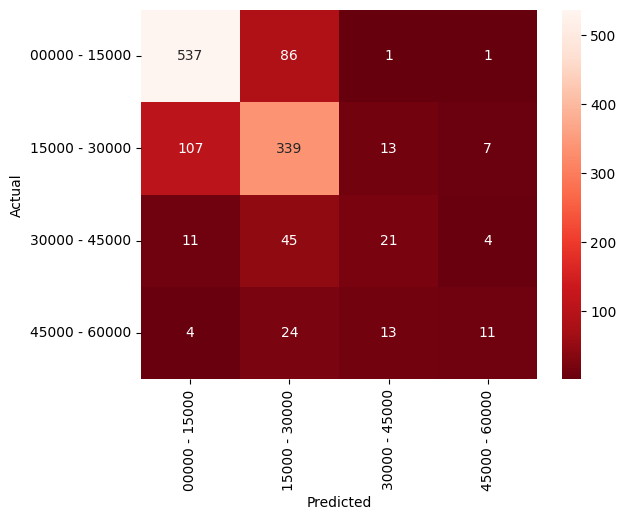

In [71]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds_r', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

🟡 Classification report ile tahminlerin başarısının değerlendirilmesi

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1 Score = 2 * (Recall * Precision) / (Recall + Precision)

Support = Number of actual occurrences of the class in the specified dataset

Macro Average: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

Weighted Average: Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.

In [72]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

00000 - 15000       0.81      0.86      0.84       625
15000 - 30000       0.69      0.73      0.71       466
30000 - 45000       0.44      0.26      0.33        81
45000 - 60000       0.48      0.21      0.29        52

     accuracy                           0.74      1224
    macro avg       0.60      0.51      0.54      1224
 weighted avg       0.73      0.74      0.73      1224



🟡 Çapraz geçerleme ve hiper parametre analizi

In [73]:
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [10, 20, 30, 40, 50]
}

In [74]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, return_train_score=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.3s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.3s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.2s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.2s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.2s
[CV] END .......model__max_depth=10, model__n_estimators=200; total time=   0.4s
[CV] END .......model__max_depth=10, model__n_estimators=200; total time=   0.4s
[CV] END .......model__max_depth=10, model__n_estimators=200; total time=   0.5s
[CV] END .......model__max_depth=10, model__n_estimators=200; total time=   0.4s
[CV] END .......model__max_depth=10, model__n_estimators=200; total time=   0.4s
[CV] END .......model__max_depth=10, model__n_estimators=300; total time=   0.7s
[CV] END .......model__max_depth=10, model__n_e

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['room',
                                                                          'living_room',
                                                                          'area',
                                                                          'age',
                                                                          'floor']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['city',
                                                                          'district',
                                                                          'neighborhood'])])),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20, 30, 40, 50],
                         'model__n_estimators': [100, 200, 300, 400, 500]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [75]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
print(f"Best estimator: {grid_search.best_estimator_}")

Best parameters: {'model__max_depth': 50, 'model__n_estimators': 400}
Best score: 0.7463201672755682
Best estimator: Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['room', 'living_room',
                                                   'area', 'age', 'floor']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'district',
                                                   'neighborhood'])])),
                ('model',
                 RandomForestClassifier(max_depth=50, n_estimators=400))])


In [76]:
model = grid_search.best_estimator_
y_pred = model.predict(X_test)

In [77]:
print(confusion_matrix(y_test, y_pred))

[[545  80   0   0]
 [107 339  13   7]
 [ 12  46  19   4]
 [  4  25  12  11]]


<Axes: >

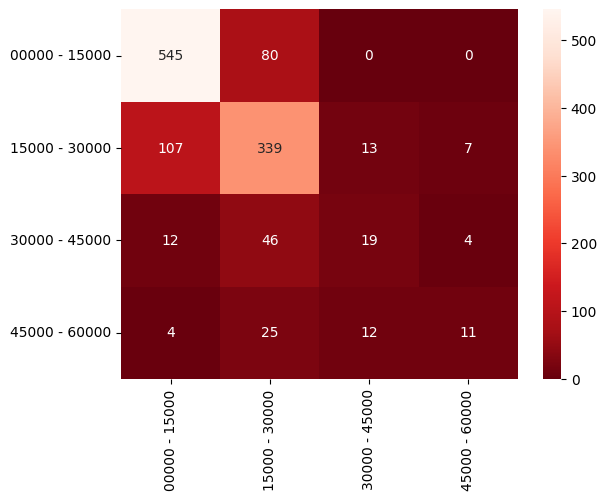

In [78]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds_r', xticklabels=labels, yticklabels=labels)

In [79]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

00000 - 15000       0.82      0.87      0.84       625
15000 - 30000       0.69      0.73      0.71       466
30000 - 45000       0.43      0.23      0.30        81
45000 - 60000       0.50      0.21      0.30        52

     accuracy                           0.75      1224
    macro avg       0.61      0.51      0.54      1224
 weighted avg       0.73      0.75      0.73      1224



💾 Modelin kaydedilmesi

In [80]:
joblib.dump(model, 'model_classification.pkl')

['model_classification.pkl']